# Régression & optimisation par descente de gradient

Ce tme a deux objectifs: 
 - acquérir les connaissances de base pour faire face au problème de la régression, c'est à dire de l'estimation d'un score réel correpondant à une situation,
 - travailler sur les techniques d'optimisation par descente de gradient

In [1]:
import numpy as np
import pickle as pkl
import matplotlib.pyplot as plt


from math import *
from random import *
np.random.seed(0)
import time


%matplotlib notebook

## Informations importantes pour le correcteur : 

Dans la suite je me suis permis de changer les notations des variables pour qu'elles soient plus lisibles et differenciables quand je veux relancer une partie du code.
Ainsi quand une variable à un 
- `l` à côté, elle correspond au cas linéire 
- `p` à côté, elle correspond au cas polynomiale
- quand il n'y a rien à côté, elle correspond à l'étude de cas sur les voitures

## Génération de données jouet & construction d'une solution analytique

Dans un premier temps, générons des données jouets paramétriques:
 - $N$: nombre de points à générer
 - $x \in [0, 1]$ tirage avec un simple rand() ou un linspace() -au choix-
     - Si vous optez pour un tirage aléatoire des abscisses, triez les points pour simplifier les traitements ultérieurs
 - $y=ax+b+\epsilon, \epsilon \sim \mathcal N(0,\sigma^2)$
     - Rappel : en multipliant un tirage aléatoire selon une gaussienne centrée réduite par $\sigma$ on obtient le bruit décrit ci-dessus

Afin de travailler sur les bonnes pratiques, nous distinguerons un ensemble d'apprentissage et un ensemble de test.
Les deux sont tirés selon la même distribution. L'ensemble de test comptera -arbitrairement- 1000 points.

In [2]:
def gen_data_lin(a, b, sig, N=500, Ntest=1000, rand = False):
    """
    a , b , sig : float, N : (500) int, Ntest : (1000), rand : False
    N : le nombre de points pour la base d'apprentissage 
    Ntest :  le nombre de points pour la base de test
    rand : si True retourne des points au hasard entre 0 et 1, sinon des points equidistants entre 0 et 1
    retourne les bases d'apprentissage et de test pour y = ax + b + epsilon
    """
    #A compléter
    if rand == True:
        X_train = np.sort([random() for n in range(N)])
        X_test  = np.sort([random() for n in range(Ntest)])
    else:
        X_train = np.linspace(0,1, N)
        X_test  = np.linspace(0,1, Ntest)
    y_train = a*X_train + np.full_like(X_train,b) + np.random.randn(N)*sig
    y_test = a*X_test + np.full_like(X_test,b) + np.random.randn(Ntest)*sig
    return X_train, y_train, X_test, y_test



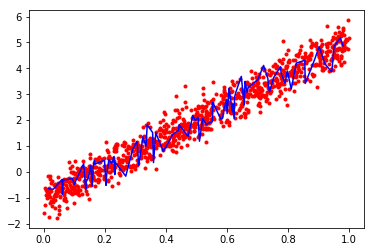

In [37]:
# génération de données jouets:
a = 6.
b = -1.
N = 100
sig = .4 # écart type

Xl_train, yl_train, Xl_test, yl_test = gen_data_lin(a, b, sig, N, rand = True)

plt.figure()
plt.plot(Xl_test, yl_test, 'r.')
plt.plot(Xl_train, yl_train, 'b')

Vous devez obtenir quelque chose de la forme:
![données jouet](fig/gen_data.png)

## Validation des formules analytiques
Nous avons vu deux types de résolutions analytique: à partir des estimateurs des espérances et co-variances d'une part et des moindres carrés d'autre part. Testons les deux méthodes.

### Estimation de paramètres probabilistes
 - $\hat a = \frac{\mbox{cov}(X,Y)}{\sigma_x^2}$
 - $\hat b = E(Y)−\frac{\mbox{cov}(X,Y)}{\sigma_x^2} E(X)$
 
 Estimer les paramètres, calculer l'erreur au sens des moindres carrés sur les données d'apprentissage et de test, puis tracer la droite de régression

In [38]:
def modele_lin_analytique(X_train, y_train):
    # A compléter
    #On va chercher la valeur de conv dans la matrice de variance covariance 
    cov = np.cov(X_train, y_train)[0,1]
    sig_X = np.var(X_train)
    E_X = np.mean(X_train)
    E_y = np.mean(y_train)
    ahat = cov/sig_X
    bhat = E_y - ahat*E_X
    
    return ahat, bhat

ahat, bhat = modele_lin_analytique(Xl_train, yl_train)
print("â = %f"%ahat)
print("b = %f"%bhat)

â = 6.051238
b = -1.048234


In [39]:
def erreur_mc(y, yhat):
    return ((y-yhat)**2).mean()

yhat_train = ahat*Xl_train + bhat
yhat_test  = ahat*Xl_test + bhat

print('Erreur moyenne au sens des moindres carrés (train):', erreur_mc(yhat_train, yl_train))
print('Erreur moyenne au sens des moindres carrés (test):', erreur_mc(yhat_test, yl_test))

Erreur moyenne au sens des moindres carrés (train): 0.15022858397256067
Erreur moyenne au sens des moindres carrés (test): 0.15600140113194672


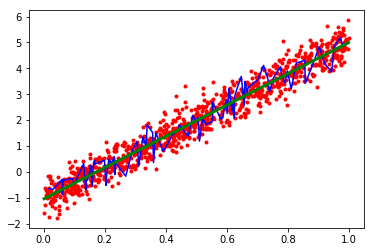

In [40]:
plt.figure()
plt.plot(Xl_test, yl_test, 'r.')
plt.plot(Xl_train, yl_train, 'b')
plt.plot(Xl_test, yhat_test, 'g', lw=3)

## Formulation au sens des moindres carrés

Nous partons directement sur une écriture matricielle. Du coup, il est nécessaire de construire la matrice enrichie $Xe$:
    $$Xe = \left[\begin{array}{cc}
                X_0 & 1\\
                \vdots & \vdots\\
                X_N & 1
                \end{array}
                \right] $$
Le code de la fonction d'enrichissement est donné ci-dessous.

Il faut ensuite poser et résoudre un système d'équations linéaires de la forme:
$$ A w = B $$
**Rappel des formules vues en cours/TD:**
$$ A=Xe^T Xe$$
$$ B=Xe^T Y$$
$$ Xe^T Xe  w = Xe^T Y$$
Fonction de résolution: `np.linalg.solve(A,B)`
Vous devez obtenir la même solution que précédemment. 

In [41]:
def make_mat_lin_biais(X): # fonctionne pour un vecteur unidimensionel X
    """
    X : nd.array(float)
    retourne la matrice enrichie Xe
    """
    N = len(X)
    return np.hstack((X.reshape(N,1),np.ones((N,1))))

In [42]:
Xel = make_mat_lin_biais(Xl_train)
# A compléter
Al = (Xel.T).dot(Xel)
Bl = (Xel.T).dot(yl_train)

wl = np.linalg.solve(Al, Bl)
print(wl)

[ 5.99072524 -1.01823602]


Pour résoudre le système on pourrait aussi passer par la fonction `np.linalg.inv` qui nous inverse une matrice mais souvent ceci conduit à des résulats moins précis comme en témoigne les résultats suivants où j'ai comparé l'erreur par rapport aux valeurs de `a` et `b` intiales pour les deux fonctions de résolutions. On observe bien que la deuxiéme erreur est plus grande.

In [43]:
w2 = np.linalg.inv(Al).dot(Bl)
print(w2)

[ 5.99072524 -1.01823602]


In [44]:
np.sqrt(np.power(w2-np.array([a,b]), 2)) > np.sqrt(np.power(wl-np.array([a,b]), 2))

array([ True,  True])

Soit les données polynomiales générées avec la fonction ci-dessous
 - proposer & une solution d'enrichissement (vue en cours et TD) 
 - résoudre analytiquement le problème des moindres carrés
 - calculer l'erreur au sens des moindes carrés en apprentissage ET en test
 - tracer les données et la solution

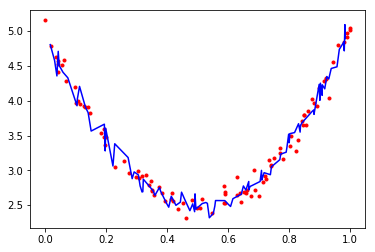

In [11]:
def gen_data_poly2(a, b, c, sig, N=500, Ntest=1000):
    '''
    Tire N points X aléatoirement entre 0 et 1 et génère y = ax^2 + bx + c + eps
    eps ~ N(0, sig^2)
    '''
    X_train = np.sort(np.random.rand(N))
    X_test  = np.sort(np.random.rand(Ntest))
    y_train = a * X_train ** 2 + b * X_train + c + np.random.randn(N) * sig
    y_test  = a *  X_test ** 2 + b *  X_test + c + np.random.randn(Ntest) * sig
    return X_train, y_train, X_test, y_test

Xp_train, yp_train, Xp_test, yp_test = gen_data_poly2(10, -10, 5, 0.1, N=100, Ntest=100)
plt.figure()
plt.plot(Xp_test, yp_test, 'r.')
plt.plot(Xp_train, yp_train, 'b')

In [12]:
def make_mat_poly_biais(X): # fonctionne pour un vecteur unidimensionel X
    """
    X : nd.array(float)
    retourne la matrice enrichie Xe pour le cas general
    """
    # A compléter
    N = len(X)
    X2 = np.power(X,2)
    return np.hstack((X2.reshape(N,1),X.reshape(N,1),np.ones((N,1))))

Xep   = make_mat_poly_biais(Xp_train)
Xep_t = make_mat_poly_biais(Xp_test)

wp    = np.linalg.solve((Xep.T).dot(Xep), (Xep.T).dot(yp_train))# A compléter 
wp_t  = np.linalg.solve((Xep_t.T).dot(Xep_t), (Xep_t.T).dot(yp_test))

yhatl   = wp[0] * Xp_train**2 + wp[1]* Xp_train + wp[2]   # A compléter
#yhat_t = wp_t[0] * Xp_test**2 + wp_t[1]* Xp_test + wp_t[2]
yhatl_t = wp[0] * Xp_test**2 + wp[1]* Xp_test + wp[2]

print('Erreur moyenne au sens des moindres carrés (train):', erreur_mc(yhatl, yp_train))
print('Erreur moyenne au sens des moindres carrés (test):', erreur_mc(yhatl_t, yp_test))


Erreur moyenne au sens des moindres carrés (train): 0.010096996621225984
Erreur moyenne au sens des moindres carrés (test): 0.010997331077548522


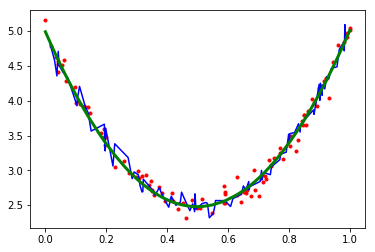

In [13]:
plt.figure()
plt.plot(Xp_test, yp_test, 'r.')
plt.plot(Xp_train, yp_train, 'b')
plt.plot(Xp_test, yhatl_t, 'g', lw=3)

# Fonction de coût & optimisation par descente de gradient

Comme vu en TD et en cours, nous allons maintenant résoudre le problème de la régression par minimisation d'une fonction de coût:
$$ C = \sum_{i=1}^N (y_i - f(x_i))$$

Soit un problème avec des données $(x_i,y_i)_{i=1,\ldots,N}$, une fonction de décision/prédiction paramétrée par un vecteur $w$ et une fonction de cout à optimiser $C(w)$.
Notre but est de trouver les paramètres $w^\star$ minimisant la fonction de coût:
$$ w^\star = \arg\min_w C(w)$$

l'algorithme de la descente de gradient est le suivant (rappel):

 - $w_0 \leftarrow init$ par exemple : 0
 - boucle
     - $w_{t+1} \leftarrow w_{t} - \epsilon \nabla_w C(w_t)$

Compléter le squelette d'implémentation fourni ci-dessous:


In [14]:
# pour travailler en matrice: (re)construction de la matrice contenant les X et un biais
Xel = make_mat_lin_biais(Xl_train) # dataset linéaire, transformation lineaire des données
wstar = wl # A compléter # pour se rappeler du w optimal

def descente_grad_mc(X, y, eps=1e-4, nIterations=100):
    """
    X : nd.array(float), y : nd.array(float), eps : (1e-4) float, nIterations : (100) int
    retourne le w optimal ainsi que la liste des w succesifs grâce à la méthode du gradient
    """
    w = np.zeros(X.shape[1]) # init à 0
    allw = [np.zeros(X.shape[1])]
    for i in range(nIterations):
        # A COMPLETER => calcul du gradient vu en TD
        grad = 2*(X.T).dot((X.dot(w) - y))
        w = allw[-1] - eps*grad
        allw.append(np.array(w)) # stockage de toutes les valeurs intermédiaires pour analyse

    allw = np.array(allw)
    return w, allw # la dernière valeur (meilleure) + tout l'historique pour le plot
    
w_opti, allw = descente_grad_mc(Xel, yl_train, eps=1e-4, nIterations=200)

On s'intéresse ensuite à comprendre la descente de gradient dans l'espace des paramètres. Le code ci-dessous permet de tracer le cout pour un ensemble de paramètres (toutes les valeurs de paramètres prises par l'algorithmes au fil du temps).


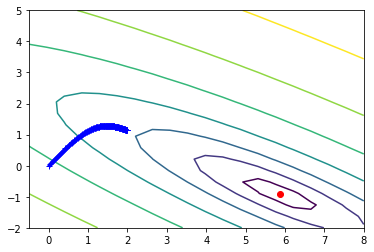

In [15]:
# tracer de l'espace des couts
def plot_parametres( allw, X, y, opti = [], ngrid = 20, extract_bornes=False):
    '''
    Fonction de tracer d'un historique de coefficients
    ATTENTION: ca ne marche qu'en 2D (évidemment)
    Chaque w doit contenir 2 valeurs
    
    Il faut fournir les données (X,y) pour calculer le cout associé 
    à un jeu de paramètres w
    ATTENTION X = forme matricielle des données
    '''
    w_min = [-0.5, -2] # bornes par défaut, uniquement pour notre cas d'usage
    w_max = [8, 5]
    if extract_bornes: # bornes générales
        w_min = np.min(allw,0) # trouver les bornes
        w_max = np.max(allw,0)
    # faire une grille régulière avec tous les couples possibles entre le min et le max
    w1range = np.linspace(w_min[0], w_max[0], ngrid)
    w2range = np.linspace(w_min[1], w_max[1], ngrid)
    w1,w2 = np.meshgrid(w1range,w2range)
    #
    # calcul de tous les couts associés à tous les couples de paramètres
    cost = np.array([[np.log(((X @ np.array([w1i,w2j])-y)**2).sum()) for w1i in w1range] for w2j in w2range])
    #
    plt.figure()
    plt.contour(w1, w2, cost)
    if len(opti) > 0:
        plt.scatter(wstar[0], wstar[1],c='r')
    plt.plot(allw[:,0],allw[:,1],'b+-' ,lw=2 )
    return
    
plot_parametres( allw, Xel, yl_train, opti=wstar)
# plt.savefig('fig/grad_descente.png')

Vous devez obtenir un image de la forme :
![Descente de gradient](fig/grad_descente.png)

Tester différents jeux de paramètres pour mettre en évidence les phénomènes suivants:
 - Divergence du gradient
 - Convergence incomplète (trop lente ou pas assez d'itération)
 - Convergence idéale: pas de gradient suffisamment grand et nombre d'itérations bien choisi

# Passage sur des données réelles

Après avoir étudié trois manières de faire face au problème de la régression, nous proposons d'étudier un cas réel: la prédiction de la consommation des voitures en fonction de leurs caractéristiques.

Dans le cas présent, nous allons baser la solution sur la résolution analytique du problème des moindres carrés (`np.linalg.solve(A,B)`), qui semble la mieux adaptée au problème qui nous intéresse.

Le jeu de données est issu des datasets UCI, un répertoire parmi les plus connus en machine learning. Les données **sont déjà téléchargées et présentes dans le tme** mais vous voulez plus d'informations:
https://archive.ics.uci.edu/ml/datasets/auto+mpg

![voiture](fig/Large9.jpg)

Après avoir importé les données (fonction fournie), vous construirez une solution optimale et l'évaluerez au sens des moindres carrés en apprentissage et en test.


In [16]:
import pandas as pd
# Chargement des données
data = pd.read_csv('data/auto-mpg.data', delimiter='\s+', header=None) # comme np.loadtxt mais en plus robuste
# remplacement des données manquantes '?' => Nan pour travailler sur des nombres
data.iloc[:,[3]] = data.iloc[:,[3]].replace('?', None)
data.iloc[:,[3]] = data.iloc[:,[3]].astype(float)
# remplacement des valeurs manquantes par la moyenne
data.iloc[:,[3]] = data.iloc[:,[3]].fillna(data.iloc[:,[3]].mean())

print(data.head()) # visualiser ce qu'il y a dans les données

X = np.array(data.values[:,1:-2], dtype=np.float64)
y = np.array(data.values[:,0], dtype=np.float64)


      0  1      2      3       4     5   6  7                          8
0  18.0  8  307.0  130.0  3504.0  12.0  70  1  chevrolet chevelle malibu
1  15.0  8  350.0  165.0  3693.0  11.5  70  1          buick skylark 320
2  18.0  8  318.0  150.0  3436.0  11.0  70  1         plymouth satellite
3  16.0  8  304.0  150.0  3433.0  12.0  70  1              amc rebel sst
4  17.0  8  302.0  140.0  3449.0  10.5  70  1                ford torino


In [18]:
# separartion app/test
def separation_train_test(X, y, pc_train=0.75):
    """
    X : nd.array(float), y : nd.array(float), pc_train : (0.75) float
    pc_train : pourcentage de valeurs dans la base d'apprentissage
    retourne les bases d'apprentissage et de test pour X et y
    """
    # A compléter
    # 1) générer tous les index entre 0 et N-1
    N = X.shape[0]
    index = np.array([i for i in range(N)])
    # 2) mélanger la liste
    shuffle(index) # permet de mélanger la liste 
    napp = int(len(y)*pc_train) # nb de points pour le train
    X_train, y_train = X[index[:napp]], y[index[:napp]]
    X_test, y_test   = X[index[napp:]], y[index[napp:]]
    return X_train, y_train, X_test, y_test

X_train, y_train, X_test, y_test = separation_train_test(X, y, pc_train=0.75)

In [19]:
# Résolution analytique

# A compléter
A = (X_train.T).dot(X_train)
B = (X_train.T).dot(y_train)

A_t = (X_test.T).dot(X_test)
B_t = (X_test.T).dot(y_test)

#w_car = np.linalg.solve(A_car,B_car)
w = np.linalg.solve(A, B)
w_t = np.linalg.solve(A_t, B_t)

print(w)
yhat   = X_train.dot(w)# A compléter
yhat_t = X_test.dot(w)# A compléter
print('Erreur moyenne au sens des moindres carrés (train):', erreur_mc(yhat, y_train))
print('Erreur moyenne au sens des moindres carrés (test):', erreur_mc(yhat_t, y_test))


[-0.34868166  0.01276001 -0.02378505 -0.00690377 -0.03685686  0.61289543]
Erreur moyenne au sens des moindres carrés (train): 12.749068177704597
Erreur moyenne au sens des moindres carrés (test): 9.618857791863153


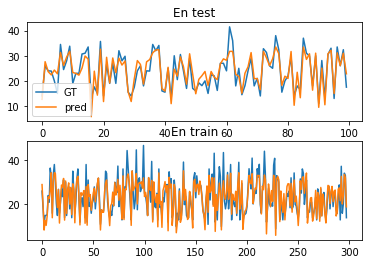

In [20]:
def plot_y(y_train, y_test, yhat, yhat_t):
    # tracé des prédictions:
    plt.figure()
    plt.subplot(211)
    plt.plot(y_test, label="GT")
    plt.plot(yhat_t, label="pred")
    plt.title('En test')
    plt.legend()
    plt.subplot(212)
    plt.plot(y_train, label="GT")
    plt.plot(yhat, label="pred")
    plt.title('En train')
    return

plot_y(y_train, y_test, yhat, yhat_t)

<BarContainer object of 6 artists>

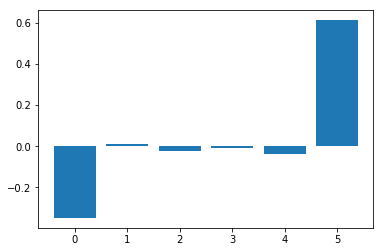

In [21]:
# interprétation des poids
plt.figure()
plt.bar(np.arange(len(w)), w)

## Normalisation

Sur le diagramme ci-dessus, on ne voit pas grand chose pour une raison évidente: on ne peut pas comparer ces poids qui comparent des variables dont les ordres de grandeur sont différents.

Nous allons donc assimiler chaque colonne $X_j$ à une variable suivant une loi normale et nous allons revenir à une Normale centrée réduite selon la formule de base:

$$X_j \sim \mathcal N(\mu_j, \sigma_j^2) $$
$$\Rightarrow Z_j = \frac{X_j - \mu_j}{\sigma_j} \sim \mathcal N(0, 1) $$

Tous les $Z_j$ sont comparables et nous seront en mesure de comprendre l'impact de chaque variables sur les résultats.

**ATTENTION:** on ne se basera que sur les données d'apprentissage pour le calcul des $\{\mu_j, \sigma_j\}$.

Une fois la normalisation effectuée, analyser l'impact des différentes variables descriptives sur la valeur à prédire.

Erreur moyenne au sens des moindres carrés (train): 12.367552928037325
Erreur moyenne au sens des moindres carrés (test): 9.664183832271206


<BarContainer object of 7 artists>

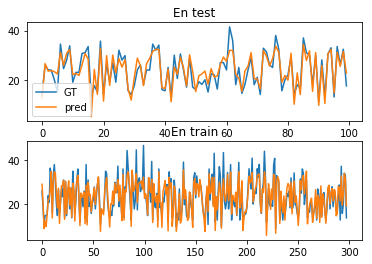

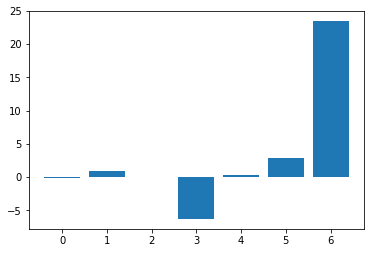

In [22]:
def normalisation(X_train, X_test):
    '''
    Fonction de normalisation des données pour rendre les colonnes comparables
    Chaque variable sera assimilée à une loi normale qu'il faut centrer + réduire.
    ATTENTION: il faut calculer les moyennes et écarts-types sur les données d'apprentissage seulement
    '''
    # A compléter
    # 1) calcul des moyennes et écarts types pour chaque colonne
    Moy, Var = np.mean(X_train,axis=0), np.std(X_train, axis= 0)
    # 2) normalisation des colonnes
    Xn_train = (X_train - Moy)/Var
    Xn_test  = (X_test - Moy) /Var
    # 3) Ajout d'un biais: fourni ci-dessous)
    Xn_train = np.hstack((Xn_train, np.ones((Xn_train.shape[0], 1))))
    Xn_test   = np.hstack((Xn_test, np.ones((X_test.shape[0], 1))))
    return Xn_train, Xn_test

Xn_train, Xn_test = normalisation(X_train, X_test)   #Variables normalisées

wn   = np.linalg.solve((Xn_train.T).dot(Xn_train), (Xn_train.T).dot(y_train))# A compléter
wn_t = np.linalg.solve((Xn_test.T).dot(Xn_test), (Xn_test.T).dot(y_test))

yhatn   = Xn_train.dot(wn)# A compléter
yhatn_t = Xn_test.dot(wn)# A compléter
#yhatn   = Xn_train[:,:-1].dot(wn[:-1])
#yhatn_t   = Xn_test[:,:-1].dot(wn[:-1])
print('Erreur moyenne au sens des moindres carrés (train):', erreur_mc(yhatn, y_train))
print('Erreur moyenne au sens des moindres carrés (test):', erreur_mc(yhatn_t, y_test))
plot_y(y_train, y_test, yhatn, yhatn_t)

plt.figure()
plt.bar(np.arange(len(wn)), wn)

On peut donc voir que le bruit explique plus nos données que le reste des varaibles, ce qui nous fais nous interroger sur la validité de certaines des valeurs de y.

# Questions d'ouverture

## Sélection de caractéristiques

Quels sont les résultats obtenus en éliminant toutes les variables servent moins?

In [23]:
data.describe()

,0,1,2,3,4,5,6,7
count,398.000000,398.000000,398.000000,398.000000,398.000000,398.000000,398.000000,398.000000
mean,23.514573,5.454774,193.425879,104.178392,2970.424623,15.568090,76.010050,1.572864
std,7.815984,1.701004,104.269838,38.294837,846.841774,2.757689,3.697627,0.802055
min,9.000000,3.000000,68.000000,46.000000,1613.000000,8.000000,70.000000,1.000000
25%,17.500000,4.000000,104.250000,75.000000,2223.750000,13.825000,73.000000,1.000000
50%,23.000000,4.000000,148.500000,92.500000,2803.500000,15.500000,76.000000,1.000000
75%,29.000000,8.000000,262.000000,125.000000,3608.000000,17.175000,79.000000,2.000000
max,46.600000,8.000000,455.000000,230.000000,5140.000000,24.800000,82.000000,3.000000


In [24]:
#Xs = np.array(data[[4, 6]], dtype=np.float64)
#Xs = X[:, np.array([3,5])]
#Xs_train, ys_train, Xs_test, ys_test = separation_train_test(Xs, y, pc_train=0.75)

In [25]:
Xs_train, ys_train, Xs_test, ys_test = X_train[:,np.array([3,5])], y_train, X_test[:,np.array([3,5])], y_test

In [26]:

As = (Xs_train.T).dot(Xs_train)
Bs = (Xs_train.T).dot(ys_train)

ws = np.linalg.solve(As, Bs)

print(ws)
yhats   = Xs_train.dot(ws)# A compléter
yhats_t = Xs_test.dot(ws)# A compléter
print('Erreur moyenne au sens des moindres carrés (train):', erreur_mc(yhats, ys_train))
print('Erreur moyenne au sens des moindres carrés (test):', erreur_mc(yhats_t, ys_test))

[-0.00701371  0.5843586 ]
Erreur moyenne au sens des moindres carrés (train): 12.933216567898553
Erreur moyenne au sens des moindres carrés (test): 9.575307310989185


<BarContainer object of 2 artists>

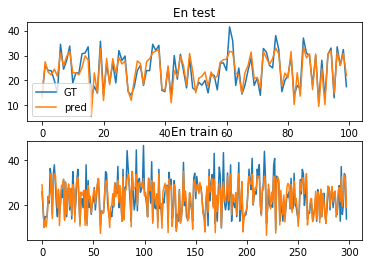

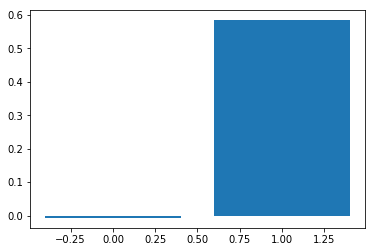

In [27]:
plot_y(ys_train, ys_test, yhats, yhats_t)
# interprétation des poids
plt.figure()
plt.bar(np.arange(len(ws)), ws)

Même sans normalisation on obtient de meilleurs résultats 

Erreur moyenne au sens des moindres carrés (train): 12.466616989455794
Erreur moyenne au sens des moindres carrés (test): 9.478345964495906


<BarContainer object of 3 artists>

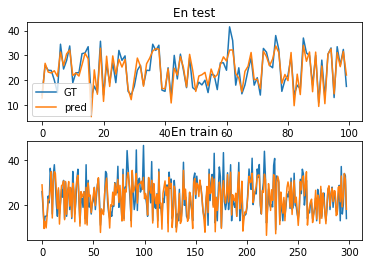

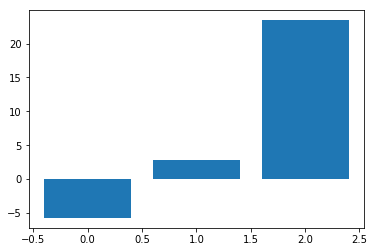

In [28]:
#XsN_train, XsN_test = normalisation(Xs_train, Xs_test)   #Variables normalisées
XsN_train, XsN_test = Xn_train[:, np.array([3,5,6])], Xn_test[:, np.array([3,5,6])]
wsN   = np.linalg.solve((XsN_train.T).dot(XsN_train), (XsN_train.T).dot(ys_train))# A compléter

yhatsN   = XsN_train.dot(wsN)# A compléter
yhatsN_t = XsN_test.dot(wsN)# A compléter
print('Erreur moyenne au sens des moindres carrés (train):', erreur_mc(yhatsN, ys_train))
print('Erreur moyenne au sens des moindres carrés (test):', erreur_mc(yhatsN_t, ys_test))
plot_y(ys_train, ys_test, yhatsN, yhatsN_t)

plt.figure()
plt.bar(np.arange(len(wsN)), wsN)

On aurait pu par exemple réaliser une ACP pour limiter le nombre de varaiables utilisées dans l'analyse.

## Feature engineering

En étudiant la signification des variables du problèmes, on trouve:

1. mpg: continuous 
2. cylinders: multi-valued discrete 
3. displacement: continuous 
4. horsepower: continuous 
5. weight: continuous 
6. acceleration: continuous 
7. model year: multi-valued discrete 
8. origin: multi-valued discrete 

D'après la question précédente, le poids, l'année du modèle et le biais sont des facteurs important pour le calcul de la consommation... Jusqu'ici, nous n'avons pas pris en compte l'origine qui était difficile à coder.

### Encodage de l'origine

La variable origine est accessible de la manière suivante:

```
  origine = data.values[:,-2]
```
Il faut le faire au début du traitement pour bien conserver la séparation en l'apprentissage et le test.

Au moins les deux derniers facteurs discrets pourraient être traités différemment en one-hot encoding:
$$X_j = x \in \{1, \ldots, K\} \Rightarrow [0, 0, 1, 0] \in \{0, 1\}^K$$

La valeur $x$ donne l'index de la colonne non nulle.

### Encodage de l'année

Pour l'année, il est possible de procéder de la même manière, mais il préférable de découper les années en 10 catégories puis d'encoder pour limiter le nombre de dimensions.

# Question d'ouverture sur le gradient

## La normalisation a-t-elle un impact sur le gradient?

La normalisation des données peut au moins nous aider à régler plus facilement le pas (qui sera toujours du même ordre de grandeur... Mais cela a-t-il un impact sur la manière dont nous nous rapprochons de la solution optimale?

## Gradient stochastique

Dans la plupart des algorithmes modernes d'optimisation liés aux réseaux de neurones, le gradient est calculé de manière stochastique, sur un exemple à la fois:

- $w_0 \leftarrow init$ par exemple : 0
- boucle
     - tirage d'une donnée $i$: $(x_i,y_i)$
     - $w_{t+1} \leftarrow w_{t} - \epsilon \nabla_w C_i(w)$


Etudier le fonctionnement de cet algorithme sur les exemples jouets précédents.

## Amélioration du gradient

Le blog de S. Ruder explique particulièrement bien les améliorations possibles sur les descentes de gradient.

https://ruder.io/optimizing-gradient-descent/

Comparer une descente de gradient stochastique avec et sans moment sur les données jouets des premières questions.